In [7]:
# Since the beginning of the challenge I've been wanting to use in some way the 'networkx' package
# just to familiarize with it. I first though about it during the Day?? challenge (the one of the 
# orbit transfers). Back then I thought that however it would have been kind of cheating, or at least 
# I wanted to follow a more standard approach. With this challenge I've decided to give it a try.

import networkx as nx
import re
import matplotlib as mpl
import matplotlib.pyplot as plt


# First I'll explain by what logic the input data was combined into a network structure. I followed a very
# natural approach. Let's say our input data get combined in a DIRECTED NETWORK in which:
# - every node is a chemical compound found in the data
# - an edge between two nodes means that the corresponding elements are
#   part of a reaction. Since the graph is directed, we can think of an edge as an arrow, whose direction
#   represents which is the reactant and which the product. Every node can have
#   1 or more arrows pointing to it (except for 'ORE', which has none), which means that more 
#   reactant are needed to produce it, e.g. in the reaction:
#              '1 A + 1 B => 1 C'
#   node C will have 2 arrows pointing to it, one from node A and one from node B. Since, as
#   specified in the assignment, every chemical is produced by exactly 1 reaction, 
#   this arranging of arrows causes no confusion. 
#   Similarly, every node can have 1 or more arrows coming out of it (except for 'FUEL', which has none), 
#   since the same chemical can appear as a reactant in more than 1 reaction.
# - every node has a 'unit' attribute, an integer value given by the amount in which the corresponding element
#   is produced in the reaction given in the input data. It is the minimum quantity of that element
#   that can be produced.
# - nodes also have a 'mass' attribute, which stores how much of that element is actually
#   stored in the node. It must be an integer multiple of the node's 'unit'. While 'unit'
#   is a constant variable for each node, 'mass' will change while working on the network.
# - every edge has a 'weight', another integer which indicates how much of the
#   corresponding reactant (start of the arrow) is needed to produce the product (end of the arrow). 
#   Again, this value is given by the reactions in the input data, and does never change during the program.
# - finallly, edges also have an attribute called 'multiplicity', which indicates HOW MANY TIMES
#   the given reaction must be run to create the amount of product stored in the 'mass'
#   variable of the corresponding node.
#
# While 'unit' attributes for nodes and 'weight' attributes for edges are straight-forward,  
# 'mass' and 'multiplicity' bring some more structure to the network, which is needed to solve
# both Part 1 and Part 2. To understand how, let's consider a single node. In general, it will have 
# arrows coming in and out of it, all with different weights and multiplicities. The basic principle 
# behind the 'balance_network()' function is to check, for every node in the network, 
# if the total request for the corresponding element is greater than the currently available quantity, 
# and to update the resources if it isn't. More specifically, the total request associated with
# a node is given by the sum over all OUTGOING edges of their 'weights' attributes times their
# 'multiplicities' attributes. The available quantity of that element is instead given by 
# the 'mass' attribute of the node. If the former is greater than the latter we have to run the reaction 
# that produce the element as many times as to revert the situation. This means, not only
# updating the 'mass' of the node to a greater value, but also increasing the 'multiplicity' attribute 
# of all the edges COMING INTO the node: if we need double of 'C' (where 'C' is produced as above) then
# we will need also double the REQUEST of 'A' and 'B'. 
# One can imagine that by repeating this 'balance' procedure for every node in the graph, 
# and by iterating the procedure few times, the multiplicities settle to a value for which the
# network has reached an 'equilibrium': every node has enough of its element to satisfy all the 
# outgoing requests. 
#
# Here is the function that implements this balance procedure for the network.
def balance_network(net, fuel):

    # Reset network state. The algorithm only works if the masses for all nodes are
    # initially equal to the amounts produced in the basic reactions given as puzzle input.
    # Accordingly, the multiplicities must all be set to 1.
    reset_network_state(net)
    
    # Set the desired level of fuel we want to obtain. The algorithm will then balance
    # the masses and multiplicities of nodes and edges of the network to achieve this goal.
    set_desired_fuel(net, fuel)
    
    balance = False
    
    while balance is not True:
    
        balance = True
        
        # For all nodes in the network
        for elem in net.nodes:
            
            # Skip if element is 'ORE'. For this element we do not have a particular weigth, 
            # since we can in principle collect how much we want of it.
            if elem == 'ORE':
                continue
            
            # Total request for current element
            request = 0
    
            # Consider links going out from the node
            for out_link in net.out_edges(elem):
            
                # Take weight and multiplicity of link, multiply them and add all results
                # to find the total request for the current element.
                weight_of_edge = net.edges[out_link[0], out_link[1]]['weight']
                multiplicity = net.edges[out_link[0], out_link[1]]['multiplicity']
                request += weight_of_edge*multiplicity
    
            
            # Set current available quantity and basic unit of the element
            available = net.nodes[elem]['mass']
            unit = net.nodes[elem]['unit']
            
            # If the request is greater than the available quantity, update variables           
            if request > net.nodes[elem]['mass']:
                
                if (request - available)%unit == 0:
                    factor = (request - available)//unit
                else:
                    factor = ((request - available)//unit)+1 
                
                # Increment mass of element in units of 'unit'
                net.nodes[elem]['mass'] += factor*unit
                
                # Increment 'multiplicities' of edges coming into the node
                for in_link in net.in_edges(elem):
                    net.edges[in_link[0], in_link[1]]['multiplicity'] += factor

                balance = False 
                    
    return 
 

    
def set_desired_fuel(net, fuel):

    net.nodes['FUEL']['mass'] = fuel
    for edge in net.in_edges('FUEL'):
        net.edges[edge[0], edge[1]]['multiplicity'] = fuel
        
    return 


# Get the total amount of ORE requested. This function is to be called only AFTER the balancing algorithm.
# Otherwise it would just give the total ORE requested in the puzzle input.
def total_ore_request(net):
    
    ore=0
    for edge in net.out_edges('ORE'):
        ore += net.edges[edge[0], edge[1]]['weight']*net.edges[edge[0], edge[1]]['multiplicity']

    return ore


# Function that resets 'mass' and 'multiplicity' attributes to original values
def reset_network_state(net):
    
    for node in net.nodes:
        net.nodes[node]['mass'] =  net.nodes[node]['unit'] if node != 'FUEL' else 0
        
        for edge in net.out_edges(node):
            net.edges[edge[0], edge[1]]['multiplicity'] = 1
            
    return

In [11]:
# Initialize a list of chemicals and of reactions from the input data.
chems = set()
react_list = []

with open('input.txt', 'r') as infile:
    for line in infile:
        
        if line == '\n':
            continue
        
        elem = [item for item in re.findall('[A-Z]*', line) if item is not '']
        quant = [int(item) for item in re.findall('[0-9]*', line) if item is not '']
        # Update method for sets allows to add elements from a list
        chems.update(elem) 
        react_list.append([item for item in zip(quant, elem)])

In [12]:
# Initialize a Directed Graph instance, and add nodes from our set of chemicals. Add the attributes
# 'unit' and 'mass' to each nde.
G = nx.DiGraph()
G.add_nodes_from(list(chems), unit = 0, mass=0)

# Add edges to the graph, and initialize the 'unit' attributes of each node. ORE will stay with unit=0.
# Also, add 'multiplicity' attribute to edges.
for item in react_list:
    product = item[-1][1]
    quantity = item[-1][0]
    G.nodes[product]['unit'] = quantity
    G.add_weighted_edges_from([(item[i][1], product, item[i][0]) for i in range(len(item)-1)], multiplicity = 1)

In [13]:
# Call the balance algorithm with a request for 1 FUEL
fuel = 1
balance_network(G, fuel)
ore_per_fuel = total_ore_request(G)
print("ORE for", fuel, "FUEL: ", ore_per_fuel)

ORE for 1 FUEL:  469536


### Part 2

In [19]:
trillion = 1000000000000

# Rough lower bound on FUEL 
lwr_bound = trillion//ore_per_fuel
print(". A lower estimate on the FUEL we can produce with ", trillion, "ORE: ", lwr_bound)
balance_network(G, 10000000)
print(". Check that to produce 10 millions FUEL we need more than 1 trillion ORE:")
print("1 trillion - total ORE for 10 million FUELS = ", trillion-total_ore_request(G))
print("\nThis two clues together imply that the FUEL produced with 1 trillion ORE is between 2 millions and 10 millions.")

. A lower estimate on the FUEL we can produce with  1000000000000 ORE:  2129762
. Check that to produce 10 millions FUEL we need more than 1 trillion ORE:
1 trillion - total ORE for 10 million FUELS =  -1990898121738

This two clues together imply that the FUEL produced with 1 trillion ORE is between 2 millions and 10 millions.


In [20]:
# With the previous information we can find the solution of Part 2 with the following algorithm, 
# in order to avoid brute-forcing.
# Starting from the lower bound of 2 millions, and knowing the fuel will be in the 'million' range, 
# the idea is to change the digits of the fuel starting from the one in the million position, 
# then the hundreds of thousands and so forth. By the end of the procedure, we will have 
# the desired amount of FUEL that can be made with no more than 1 trillion ORE.

# Split the fuel value into its digits
fuel = 2000000
cyphers = list(str(fuel))

# Cycling over the digits
for i in range(len(dis)):
    
    # Current digit to act upon
    curr = cyphers[i]
    # The remaining part of the number, as strings
    top = ''.join(cyphers[0:i]) if cyphers[0:i] is not [] else None
    end = ''.join(cyphers[i+1:]) if cyphers[i+1:] is not [] else None
        
    count = 0
    ore = 0
    while ore < trillion:
        count += 1
        # Create the new value for the fuel, glueing the different part of the number
        # with the increased current digit
        fuel = int(top+str(int(curr)+count)+end)
        # Balancing the network for that fuel value
        balance_network(G, fuel)
        # Get corresponding ore request
        ore = total_ore_request(G)        
    
    # New values of the digits of fuel
    cyphers = list(top+str(int(curr)+count-1)+end)

print("Maximum FUEL produced with 1 trillion ore: ", ''.join(cyphers))

Maximum FUEL produced with 1 trillion ore:  3343477


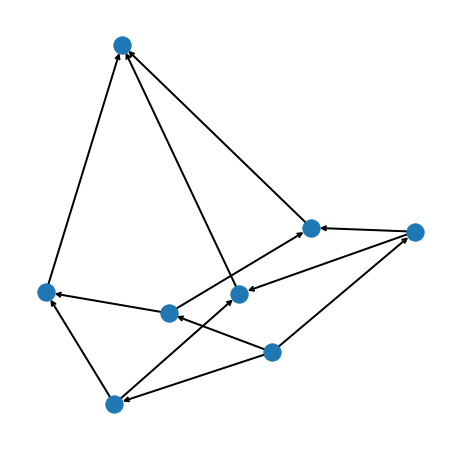

In [11]:
plt.figure(figsize=(8, 8))

pos = nx.layout.spring_layout(G, 1/G.number_of_nodes()**(1/10))
nodes = nx.draw_networkx_nodes(G, pos) # node_size=node_sizes, node_color="blue")
#nx.draw_networkx_labels(G, pos=pos)
edges = nx.draw_networkx_edges(G, pos, arrowstyle="->", width=2) #node_size=node_sizes, arrowsize=10,
                                                                #edge_color=edge_colors, edge_cmap=plt.cm.Blues,
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
#pc.set_array(edge_colors)
#plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()